# Train a binary classifier to predict default or perform data analysis to create a rule-based score card. 

Please justify your choice. Please clearly explain the methodologies and techniques used.
Describe any feature engineering that was done. What metric was used for training and why?
Think of the implication for the business.

In [1]:
from utils.get_data import get_all_data, load_training_data
import pandas as pd
from pathlib import Path
import seaborn as sns
from pylab import plt
import numpy as np
import shap
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from category_encoders import TargetEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, recall_score
from sklearn.feature_selection import SelectFromModel
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier, GradientBoostingClassifier
from sklearn.linear_model import LassoCV, LogisticRegression, RidgeClassifierCV
%load_ext autoreload
%autoreload 2

/usr/local/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Load in training data

In [3]:
bucket_name= 'kuunda-datascience-challenge'
data_path = '/app/data'

In [4]:
# download_data
#get_all_data(bucket_name,data_path)

In [5]:
# load training data
df = load_training_data(data_path)
df.head()

,customerid,loanid,date_add,prodcode,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,...,feature_57,feature_58,feature_59,feature_60,feature_61,feature_62,feature_63,feature_64,default_ind,write_off_ind
0,e1d4435674175cc4017fa46c1c2f0478314dc697b08bf4...,Agent_OD_249059589,2024-03-23 07:28:31,Overdraft,181026.11,5249757.20,130223.047090,769.95,22328.64,580.451625,...,600000.0000,2400000.0,1,-107407.4074,32,5,-312000.0,1691250.00,0,0
1,8503cedac67cad3d830aff6e1219bc301d0d41aa8cd638...,Agent_OD_252459496,2024-03-28 09:37:43,Overdraft,547723.81,16431714.40,280743.120389,1972.09,59162.88,483.518444,...,70000.0000,280000.0,1,-70000.0000,4,3,-36400.0,101250.00,0,0
2,bf68824fa3376f3c37d0d352651d5936999b1a1cbd6a6a...,Agent_OD_250556868,2024-03-25 12:15:20,Overdraft,1132610.09,33978302.80,647061.932067,2904.35,87130.56,1038.489611,...,450000.0000,450000.0,0,0.0000,1,0,-58500.0,373333.33,0,0
3,159ecbd4bf1390db4d2db4d0fd1794fbce0ced362209e4...,Agent_OD_238029220,2024-03-06 11:26:51,Overdraft,39178.82,901113.08,32345.225954,303.69,6984.96,168.435204,...,367285.7142,2571000.0,1,-101483.4516,35,11,-334230.0,760384.61,0,0
4,159ecbd4bf1390db4d2db4d0fd1794fbce0ced362209e4...,Agent_OD_238032965,2024-03-06 11:31:23,Overdraft,39178.82,901113.08,32345.225954,303.69,6984.96,168.435204,...,367285.7142,2571000.0,1,-101483.4516,35,11,-334230.0,760384.61,0,0


In [6]:
# split out features into numeric and categorica/ordinal base on data type
features = [col for col in df.columns if col.startswith('feature')]
target_col = ['default_ind']
numeric_cols = []
categorical_cols = []

for col in features:
    if pd.api.types.is_float_dtype(df[col]):
        numeric_cols.append(col)
    elif pd.api.types.is_object_dtype(df[col]) or \
         pd.api.types.is_integer_dtype(df[col]) or \
         pd.api.types.is_bool_dtype(df[col]): 
        categorical_cols.append(col)
    else:
        print(f"Warning: Column '{col}' has an unexpected dtype: {df[col].dtype}.")


In [7]:
# I'm going to assume these int features are ordinal since there are no strings
df[categorical_cols].head()

,feature_22,feature_44,feature_46,feature_49,feature_51,feature_52,feature_56,feature_59,feature_61,feature_62
0,29,179,0,1,9,1,1,1,32,5
1,30,180,1,1,1,1,1,1,4,3
2,30,180,1,0,1,0,1,0,1,0
3,23,164,0,2,2,1,1,1,35,11
4,23,164,0,2,2,1,1,1,35,11


## Create train, dev, and val sets

Assumptions for speed of challenge.
1. each loan is independant of others
2. time of year isn't important
3. the features capture prevous loans

I will use 80% for train and 10% for val and dev sets

In [8]:
# split into sets
train_val_df, dev_df = train_test_split(df, test_size=0.10)
train_df, val_df = train_test_split(train_val_df, test_size=0.10 / (1 - 0.10))
og_size=df.shape[0]
train_df.shape[0]/og_size, val_df.shape[0]/og_size, dev_df.shape[0]/og_size

(0.7999893713131743, 0.10000531434341287, 0.10000531434341287)

In [9]:
# class imbalance
train_df[target_col].sum()/train_df.shape[0],val_df[target_col].sum()/val_df.shape[0],dev_df[target_col].sum()/dev_df.shape[0]

(default_ind    0.086904
 dtype: float64,
 default_ind    0.088745
 dtype: float64,
 default_ind    0.089383
 dtype: float64)

In [10]:
# build sklearn pipeline for pre-processing

numerical_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

ordinal_categorical_transformer = Pipeline(steps=[
    ('target_encoder', TargetEncoder(cols=categorical_cols))
])


preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numeric_cols),
        ('ordinal', ordinal_categorical_transformer, categorical_cols)
    ],
    remainder='passthrough' # Keep columns not specified (e.g., target variable)
)

processed_data = preprocessor.fit_transform(train_df[features],train_df[target_col])

array([[ 0.50682295,  0.48169418,  0.73409184, ...,  0.0849762 ,
         0.09258465,  0.09388972],
       [-0.56781466, -0.56246421, -0.65600978, ...,  0.0849762 ,
         0.09033372,  0.03595555],
       [ 0.06312609,  0.07240562,  0.34525473, ...,  0.0849762 ,
         0.1109783 ,  0.16377649],
       ...,
       [-0.15463854, -0.16039304, -0.2736866 , ...,  0.0849762 ,
         0.04934688,  0.03595555],
       [-0.19857073, -0.19009379,  0.00235233, ...,  0.0849762 ,
         0.10463122,  0.05622189],
       [-0.47008115, -0.46243691, -0.54887967, ...,  0.0849762 ,
         0.10463122,  0.09968685]])

# Feature selection

In [11]:
# use a model to do feature selection
model = RandomForestClassifier()

feature_selection_pipeline = Pipeline(steps=[
    ('pre-proceesor',preprocessor),
    ('feature_selection',SelectFromModel(model)),
     ('model',model)
     ])

In [12]:
feature_selection_pipeline.fit(train_df[features],train_df[target_col])
feature_selection_pipeline

/usr/local/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/usr/local/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Pipeline(steps=[('pre-proceesor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['feature_1', 'feature_2',
                                                   'feature_3', 'feature_4',
                                                   'feature_5', 'feature_6',
                                                   'feature_7', 'feature_8',
                                                   'feature_9', 'feature_10',
                                                   'feature_11', 'feature_12',
                                                   'feature_13', 'feature_14',
                                                   'feature_15', 'feature_16',
                                                   'feature...
                                                                                       'feature_46',
                                                                                       'feature_49',
                                                                                       'feature_51',
                                                                                       'feature_52',
                                                                                       'feature_56',
                                                                                       'feature_59',
                                                                                       'feature_61',
                                                                                       'feature_62']))]),
                                                  ['feature_22', 'feature_44',
                                                   'feature_46', 'feature_49',
                                                   'feature_51', 'feature_52',
                                                   'feature_56', 'feature_59',
                                                   'feature_61',
                                                   'feature_62'])])),
                ('feature_selection',
                 SelectFromModel(estimator=RandomForestClassifier())),
                ('model', RandomForestClassifier())])

In [13]:
roc_auc_score(val_df[target_col],feature_selection_pipeline.predict(val_df[features]))

np.float64(0.6869742670013367)

In [14]:
fs_feat_index = [int(s.replace('x','')) for s in feature_selection_pipeline.named_steps['feature_selection'].get_feature_names_out()]
selected_feature_names = [s.split('__')[1] for s in feature_selection_pipeline.named_steps['pre-proceesor'].get_feature_names_out()[fs_feat_index]]
selected_feature_names

['feature_3',
 'feature_6',
 'feature_7',
 'feature_8',
 'feature_9',
 'feature_10',
 'feature_11',
 'feature_12',
 'feature_13',
 'feature_14',
 'feature_15',
 'feature_17',
 'feature_19',
 'feature_20',
 'feature_21',
 'feature_25',
 'feature_28',
 'feature_29',
 'feature_30',
 'feature_31',
 'feature_32',
 'feature_33',
 'feature_34',
 'feature_35',
 'feature_36',
 'feature_37',
 'feature_40',
 'feature_41',
 'feature_42',
 'feature_43',
 'feature_47',
 'feature_48',
 'feature_53',
 'feature_54',
 'feature_57',
 'feature_58',
 'feature_60',
 'feature_63',
 'feature_64',
 'feature_44',
 'feature_62']

In [24]:
# get shap analysis
model_for_shap = feature_selection_pipeline.named_steps['model']
X_val_for_shap = feature_selection_pipeline.named_steps['pre-proceesor'].transform(train_df[features])
X_val_for_shap = feature_selection_pipeline.named_steps['feature_selection'].transform(X_val_for_shap)
X_val_for_shap_df = pd.DataFrame(X_val_for_shap, columns=selected_feature_names)

explainer= shap.TreeExplainer(model_for_shap, X_val_for_shap_df)
sample_size = min(1000, X_val_for_shap_df.shape[0])
X_val_sample_for_shap = X_val_for_shap_df.sample(n=sample_size, random_state=42)

shap_values_class_1 = explainer.shap_values(X_val_sample_for_shap) # Assuming binary classification, 1 is the positive class



100%|===================| 1998/2000 [03:05<00:00]        

In [26]:
shap_values_class_1[:,:,1].shape

(1000, 41)

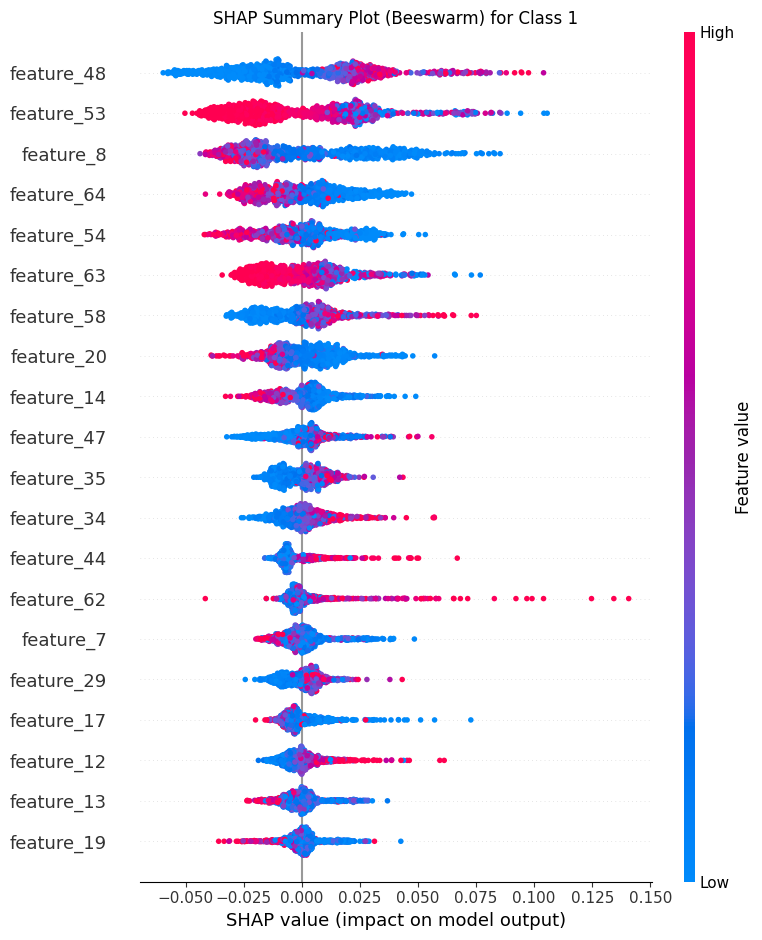

In [27]:
shap.summary_plot(shap_values_class_1[:,:,1], X_val_sample_for_shap, plot_type="dot", show=False)
plt.title("SHAP Summary Plot (Beeswarm) for Class 1")
plt.tight_layout()
plt.show()


Generating SHAP Summary Plot (Beeswarm) for Class 1 (Positive Class)...

Generating SHAP Summary Plot (Bar) for Class 1 (Global Importance)...


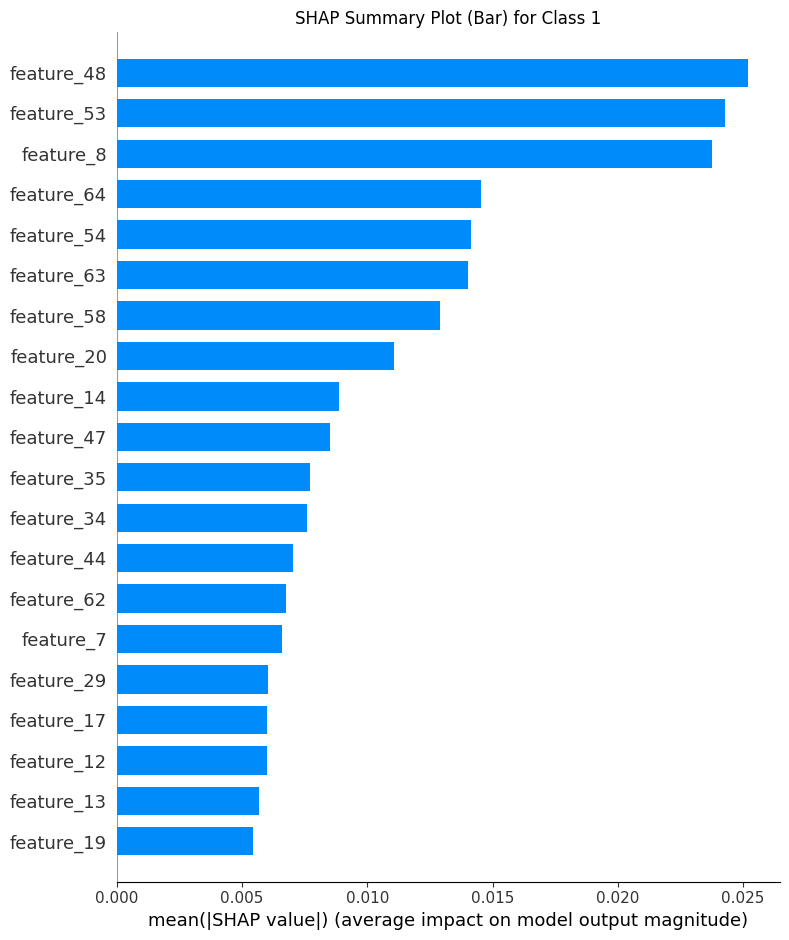

In [28]:
print("\nGenerating SHAP Summary Plot (Beeswarm) for Class 1 (Positive Class)...")


print("\nGenerating SHAP Summary Plot (Bar) for Class 1 (Global Importance)...")
shap.summary_plot(shap_values_class_1[:,:,1], X_val_sample_for_shap, plot_type="bar", show=False)
plt.title("SHAP Summary Plot (Bar) for Class 1")
plt.tight_layout()
plt.show()

In [30]:
shap.initjs() 
shap.force_plot(
    explainer.expected_value[1], # Expected value for class 1
    shap_values_class_1[:,:,1][0,:],
    X_val_sample_for_shap.iloc[0,:]
)

## Future work

Due to limitation of time i did not get to do the following steps
1. Deal with class imbalance properly. I would have tried under sampling the majority class or weighting the minority class to get the classes to roughly 50:50
2. Proper target selection. Due to the revolving nature of this credit product, i could have tried more time based aggregations for the target. 
3. create a baseline model. I usually use the dummy classifer if i don't have a model in prodution to compare against
4. Do proper feature selection and remove highly correlated features
5. Bin features using WOE binning or extracting the bins from a tree (this gives greater explainablity and model stability)
6. Hyperparmeter tuning, us Optuna or hyperopt to select the correct model and hyper parameters
7. experiment logging, using mlflow to log output from Hyperparmeter tuning and save for later
8. Proper shap analysis or if the features are binned show how the feature contribute to the model outcome
9. Boundary descisioning look at the loan amount and probablity of defaul to decide a good decision boundary for launching this model. have some curves and simulations on how the loan amount could have changed with different model discrimination (auc)